# Alphalens Example Tear Sheet for QuantRocket

*This example tear sheet from the Alphalens Github repo has been modified to use QuantRocket data. QuantRocket commentary is prefixed with [QR].*

Alphalens is designed to aid in the analysis of "alpha factors," data transformations that are used to predict future price movements of financial instruments. Alpha factors take the form of a single value for each asset on each day. The dimension of these values is not necessarily important. We evaluate an alpha factor by considering daily factor values relative to one another. 

It is important to note the difference between an alpha factor and a trading algorithm. A trading algorithm uses an alpha factor, or combination of alpha factors to generate trades.  Trading algorithms cover execution and risk constraints: the business of turning predictions into profits. Alpha factors, on the other hand, are focused soley on making predictions. This difference in scope lends itself to a difference in the methodologies used to evaluate alpha factors and trading algorithms. Alphalens does not contain analyses of things like transaction costs, capacity, or portfolio construction. Those interested in more implementation specific analyses are encouaged to check out pyfolio (https://github.com/quantopian/pyfolio), a library specifically geared towards the evaluation of trading algorithms. 





In [1]:
import alphalens

*[QR]* Let's get some QuantRocket data. Let's assume we've already created a historical database called "amex-1d".

In [2]:
from quantrocket.history import get_historical_prices

DATABASE_NAME = "amex-1d"
prices = get_historical_prices(DATABASE_NAME, start_date="2014-01-01", end_date="2017-01-01", fields=["Open","Close","Volume"])

For demonstration purposes we will create a predictive factor. To cheat we will look at future prices to make sure we'll rank high stoks that will perform well and vice versa.

In [3]:
lookahead_bias_days = 5

predictive_factor = prices.loc["Open"]
predictive_factor = predictive_factor.pct_change(lookahead_bias_days)
# introduce look-ahead bias and make the factor predictive
predictive_factor = predictive_factor.shift(-lookahead_bias_days)

predictive_factor = predictive_factor.stack()
predictive_factor.index = predictive_factor.index.set_names(['date', 'asset'])

In [4]:
predictive_factor.head()

date        asset 
2014-01-02  7087      0.015444
            9029     -0.051699
            12190     0.132948
            270422   -0.047059
            753962    0.053030
dtype: float64

The pricing data passed to alphalens should reflect the next available price after a factor value was observed at a given timestamp. The price must not be included in the calculation of the factor for that time. Always double check to ensure you are not introducing lookahead bias to your study.

In our example, before trading starts on 2014-12-2, we observe yesterday, 2014-12-1's factor value. The price we should pass to alphalens is the next available price after that factor observation: the open price on 2014-12-2.

In [5]:
pricing = prices.loc["Open"].iloc[1:]
pricing.head()

ConId       7087       9029       12190      270422     753962     754027     \
Date                                                                           
2014-01-03      10.40      20.70       5.17       4.13      13.32        NaN   
2014-01-06      10.43      20.36       5.18       4.06      13.50      14.50   
2014-01-07      10.46      19.78       5.30       4.20      13.75      14.50   
2014-01-08      10.46      19.92       5.70       4.17      13.75      13.93   
2014-01-09      10.52      19.81       5.88       4.05      13.90        NaN   

ConId       754063     754065     754237     754260       ...      267950806  \
Date                                                      ...                  
2014-01-03      13.63      21.63      36.13      20.93    ...           8.88   
2014-01-06      13.78      21.60      36.17      20.84    ...           8.33   
2014-01-07      13.62      21.83      35.99      19.24    ...           8.50   
2014-01-08      13.54      21.95      36.18        NaN    ...           9.06   
2014-01-09      13.54      21.85      36.06        NaN    ...           9.12   

ConId       269496996  271297482  273067542  274617214  274839984  277374870  \
Date                                                                           
2014-01-03       3.64       22.0        NaN      5.188       11.6      6.400   
2014-01-06       4.00       23.1        NaN      5.300       11.6      6.249   
2014-01-07       3.33       21.6        NaN      5.700       11.4      6.790   
2014-01-08        NaN       21.3        NaN      6.300       11.3      6.500   
2014-01-09       3.55       22.3        NaN      6.500       11.6      6.027   

ConId       279084571  282012655  286935287  
Date                                         
2014-01-03    16.8750       1.18       19.5  
2014-01-06    16.5000       1.17       21.5  
2014-01-07    17.5000       1.05       19.7  
2014-01-08    18.4975       1.00       20.6  
2014-01-09    17.4975       1.00       21.0  

[5 rows x 290 columns]

Often, we'd want to know how our factor looks across various groupings (sectors, industires, countries, etc.), in this example let's use sectors. To generate sector level breakdowns, you'll need to pass alphalens a sector mapping for each traded name. 

This mapping can come in the form of a MultiIndexed Series (with the same date/symbol index as your factor value) if you want to provide a sector mapping for each symbol on each day. 

If you'd like to use constant sector mappings, you may pass symbol to sector mappings as a dict.

If your sector mappings come in the form of codes (as they do in this tutorial), you may also pass alphalens a dict of sector names to use in place of sector codes.

*[QR]* Let's use QuantRocket's securities master service to get the sectors for our universe.

In [6]:
# Remind ourselves which universe(s) our history db is based on
from quantrocket.history import get_db_config
universes = get_db_config("amex-1d")["universes"]
print(universes)

['amex-stk']


In [12]:
from quantrocket.master import download_master_file
import io
import pandas as pd
f = io.StringIO()
download_master_file(f, universes=universes, fields=["Sector"], delisted=True)
securities = pd.read_csv(f, index_col="ConId")

In [13]:
ticker_sectors = securities.Sector.to_dict()

## Formatting input data

Alphalens contains a handy data formatting function to transform your factor and pricing data into the exact inputs expected by the tear sheet functions.

In [14]:
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(predictive_factor, 
                                                                   pricing, 
                                                                   quantiles=5,
                                                                   bins=None,
                                                                   groupby=ticker_sectors,
                                                                   max_loss=1)

Dropped 26.0% entries from factor data: 26.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!


In [15]:
factor_data.head()

1D        5D       10D    factor               group  \
date       asset                                                                
2014-01-03 9029   -0.016425 -0.048309  0.010145 -0.048309  Consumer, Cyclical   
           12190   0.001934  0.092843  0.073501  0.092843  Consumer, Cyclical   
           270422 -0.016949 -0.050847 -0.007264 -0.050847          Industrial   
           753962  0.013514  0.043544  0.124625  0.043544  Consumer, Cyclical   
           754237  0.001107 -0.006366  0.006089 -0.006366           Financial   

                   factor_quantile  
date       asset                    
2014-01-03 9029                  1  
           12190                 5  
           270422                1  
           753962                4  
           754237                2

You'll notice that we've placed all of the information we need for our calculations into one dataframe. Variables are the columns, and observations are each row.

The integer columns represents the forward returns or the daily price change for the N days after a timestamp. The 1 day forward return for AAPL on 2014-12-2 is the percent change in the AAPL open price on 2014-12-2 and the AAPL open price on 2014-12-3. The 5 day forward return is the percent change from open 2014-12-2 to open 2014-12-9 (5 trading days) divided by 5.

# Returns Analysis

Returns analysis gives us a raw description of a factor's value that shows us the power of a factor in real currency values.

One of the most basic ways to look at a factor's predicitve power is to look at the mean return of different factor quantile. 

In [16]:
mean_return_by_q_daily, std_err = alphalens.performance.mean_return_by_quantile(factor_data, by_date=True)

In [17]:
mean_return_by_q_daily.head()

1D        5D       10D
factor_quantile date                                    
1               2014-01-03 -0.016571 -0.084337 -0.091172
                2014-01-06 -0.021938 -0.086981 -0.085429
                2014-01-07 -0.017050 -0.093864 -0.081149
                2014-01-08 -0.015257 -0.096481 -0.114840
                2014-01-09 -0.017687 -0.104368 -0.102865

In [18]:
mean_return_by_q, std_err_by_q = alphalens.performance.mean_return_by_quantile(factor_data, by_group=False)

In [19]:
mean_return_by_q.head()

1D        5D       10D
factor_quantile                              
1               -0.025101 -0.103068 -0.096099
2               -0.006946 -0.030404 -0.029418
3               -0.000316 -0.003731 -0.004053
4                0.006294  0.021115  0.021126
5                0.026485  0.117659  0.109950

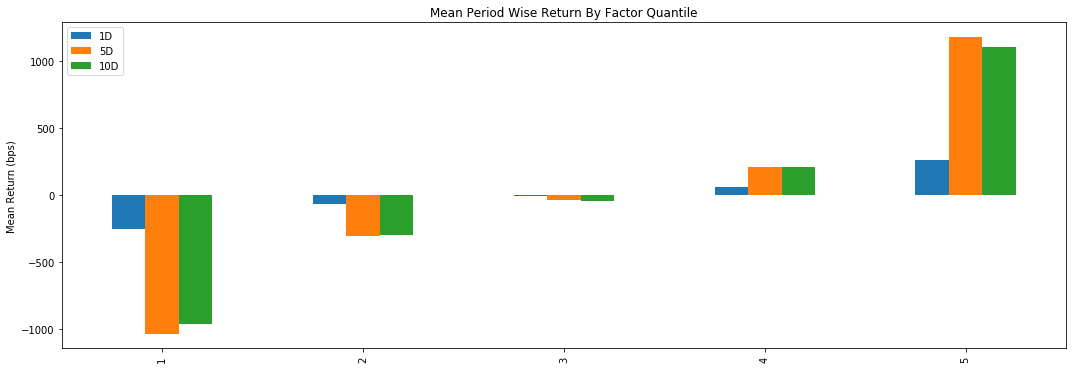

In [20]:
alphalens.plotting.plot_quantile_returns_bar(mean_return_by_q);

By looking at the mean return by quantile we can get a real look at how well the factor differentiates forward returns across the signal values. Obviously we want securities with a better signal to exhibit higher returns. For a good factor we'd expect to see negative values in the lower quartiles and positive values in the upper quantiles.

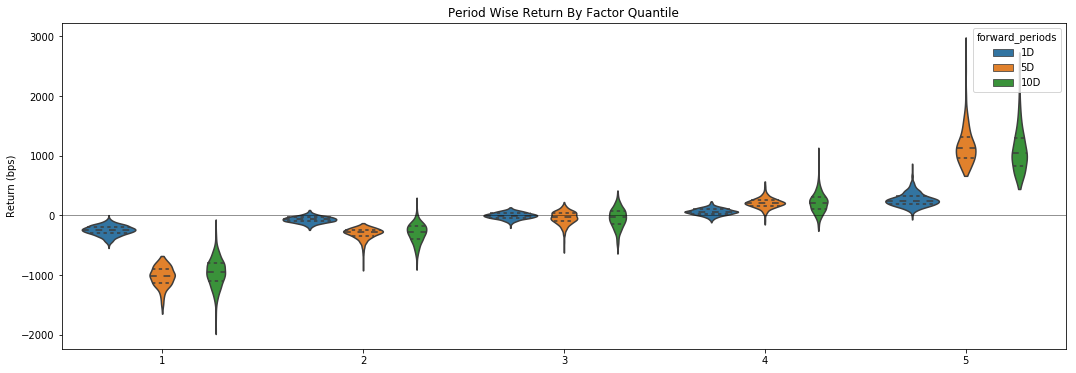

In [21]:
alphalens.plotting.plot_quantile_returns_violin(mean_return_by_q_daily);

This violin plot is similar to the one before it but shows more information about the underlying data. It gives a better idea about the range of values, the median, and the inter-quartile range. What gives the plots their shape is the application of a probability density of the data at different values.

In [22]:
quant_return_spread, std_err_spread = alphalens.performance.compute_mean_returns_spread(mean_return_by_q_daily,
                                                                                        upper_quant=5,
                                                                                        lower_quant=1,
                                                                                        std_err=std_err)

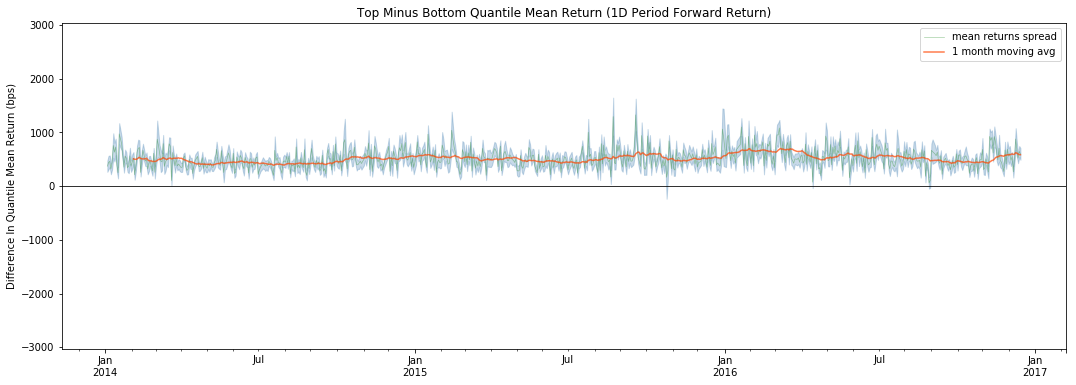

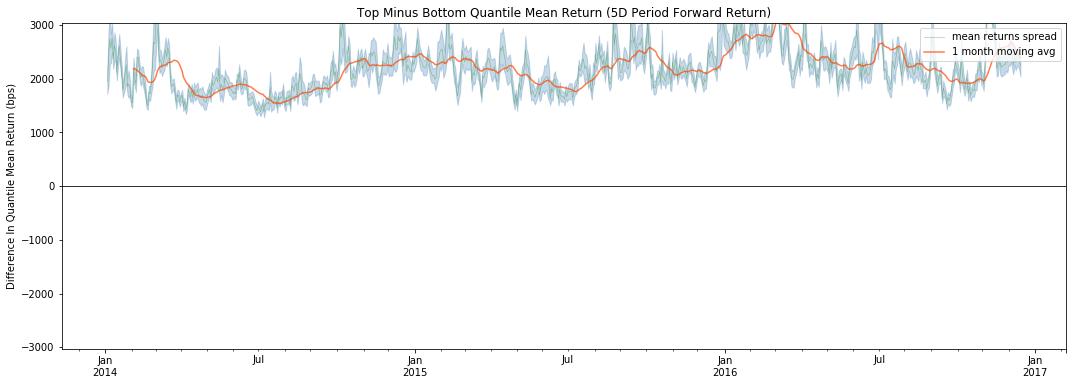

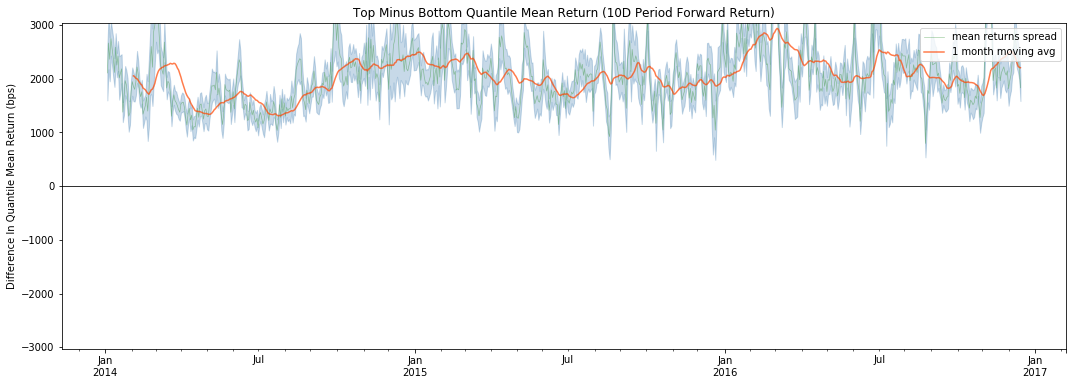

In [23]:
alphalens.plotting.plot_mean_quantile_returns_spread_time_series(quant_return_spread, std_err_spread);

This rolling forward returns spread graph allows us to look at the raw spread in basis points between the top and bottom quantiles over time. The green line is the returns spread while the orange line is a 1 month average to smooth the data and make it easier to visualize.

/opt/conda/lib/python3.6/site-packages/pandas/core/indexes/datetimes.py:962: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


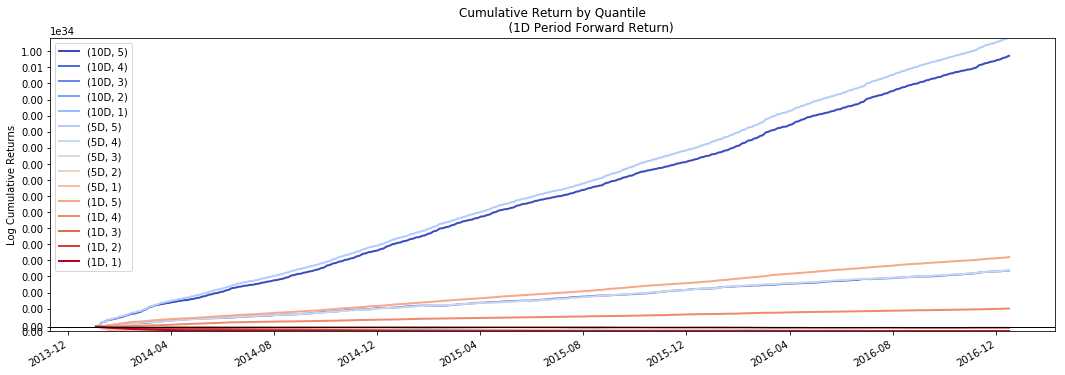

In [26]:
alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q_daily, "1D")

By looking at the cumulative returns by factor quantile we can get an intuition for which quantiles are contributing the most to the factor and at what time. Ideally we would like to see a these curves originate at the same value on the left and spread out like a fan as they move to the right through time, with the higher quantiles on the top.

In [27]:
ls_factor_returns = alphalens.performance.factor_returns(factor_data)

In [28]:
ls_factor_returns.head()

1D        5D       10D
date                                    
2014-01-03  0.026240  0.146446  0.209076
2014-01-06  0.025398  0.376701  0.290122
2014-01-07  0.029669  0.332374  0.223406
2014-01-08  0.015276  0.190885  0.192321
2014-01-09  0.038064  0.191124  0.163388

/opt/conda/lib/python3.6/site-packages/pandas/core/indexes/datetimes.py:962: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


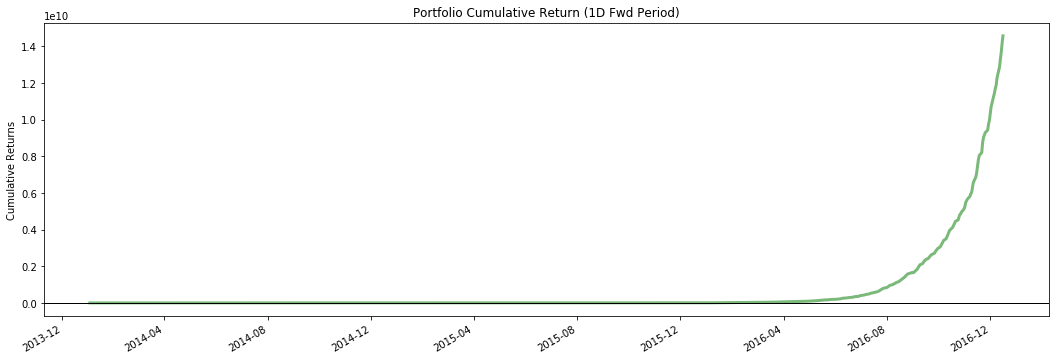

In [31]:
alphalens.plotting.plot_cumulative_returns(ls_factor_returns["1D"], "1D");

While looking at quantiles is important we must also look at the factor returns as a whole. The cumulative factor long/short returns plot lets us view the combined effects overtime of our entire factor.

In [32]:
alpha_beta = alphalens.performance.factor_alpha_beta(factor_data)

In [33]:
alpha_beta

1D           5D        10D
Ann. alpha  2674.957417  1445.524852  27.809581
beta           0.512115     1.659629   0.951563

A very important part of factor returns analysis is determing the alpha, and how significant it is. Here we surface the annualized alpha, and beta.

## Returns Tear Sheet

We can view all returns analysis calculations together.

Returns Analysis


1D        5D      10D
Ann. alpha                                     2674.957  1445.525   27.810
beta                                              0.512     1.660    0.952
Mean Period Wise Return Top Quantile (bps)      264.852   224.966  104.861
Mean Period Wise Return Bottom Quantile (bps)  -251.009  -215.202 -100.526
Mean Period Wise Spread (bps)                   513.992   438.067  204.443

/opt/conda/lib/python3.6/site-packages/pandas/core/indexes/datetimes.py:962: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


<Figure size 432x288 with 0 Axes>

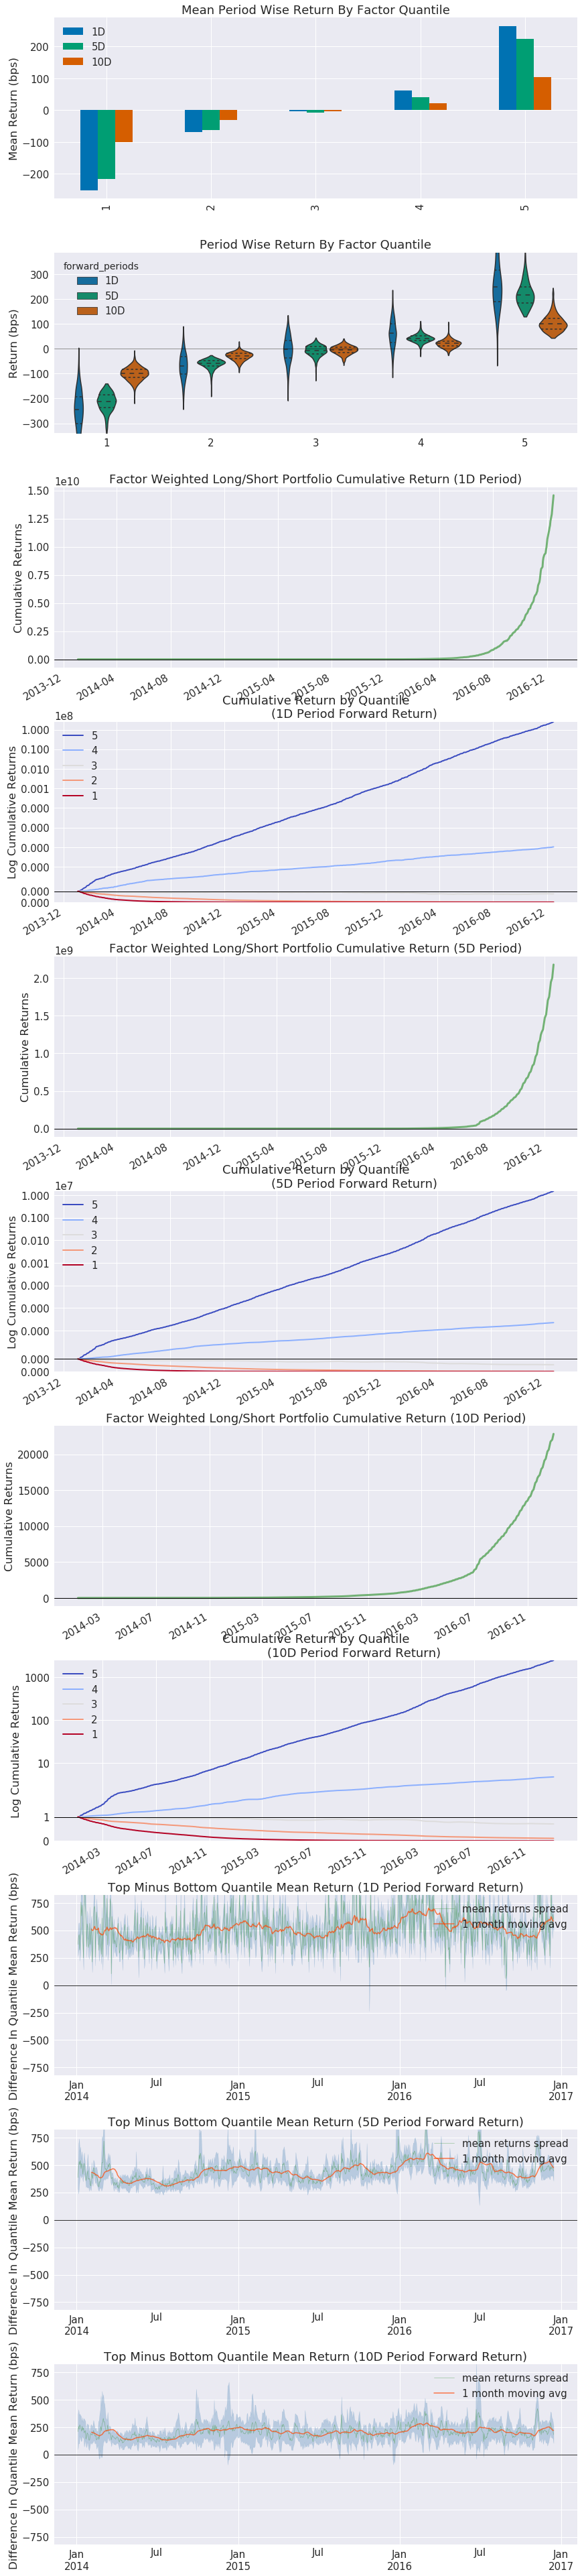

In [34]:
alphalens.tears.create_returns_tear_sheet(factor_data)

# Information Analysis

Information Analysis is a way for us to evaluate the predicitive value of a factor without the confounding effects of transaction costs. The main way we look at this is through the Information Coefficient (IC).

From Wikipedia...

>The information coefficient (IC) is a measure of the merit of a predicted value. In finance, the information coefficient is used as a performance metric for the predictive skill of a financial analyst. The information coefficient is similar to correlation in that it can be seen to measure the linear relationship between two random variables, e.g. predicted stock returns and the actualized returns. The information coefficient ranges from 0 to 1, with 0 denoting no linear relationship between predictions and actual values (poor forecasting skills) and 1 denoting a perfect linear relationship (good forecasting skills).

In [35]:
ic = alphalens.performance.factor_information_coefficient(factor_data)

In [36]:
ic.head()

1D   5D       10D
date                               
2014-01-03  0.368526  1.0  0.544198
2014-01-06  0.312566  1.0  0.584344
2014-01-07  0.369659  1.0  0.637761
2014-01-08  0.357850  1.0  0.699164
2014-01-09  0.402108  1.0  0.710574

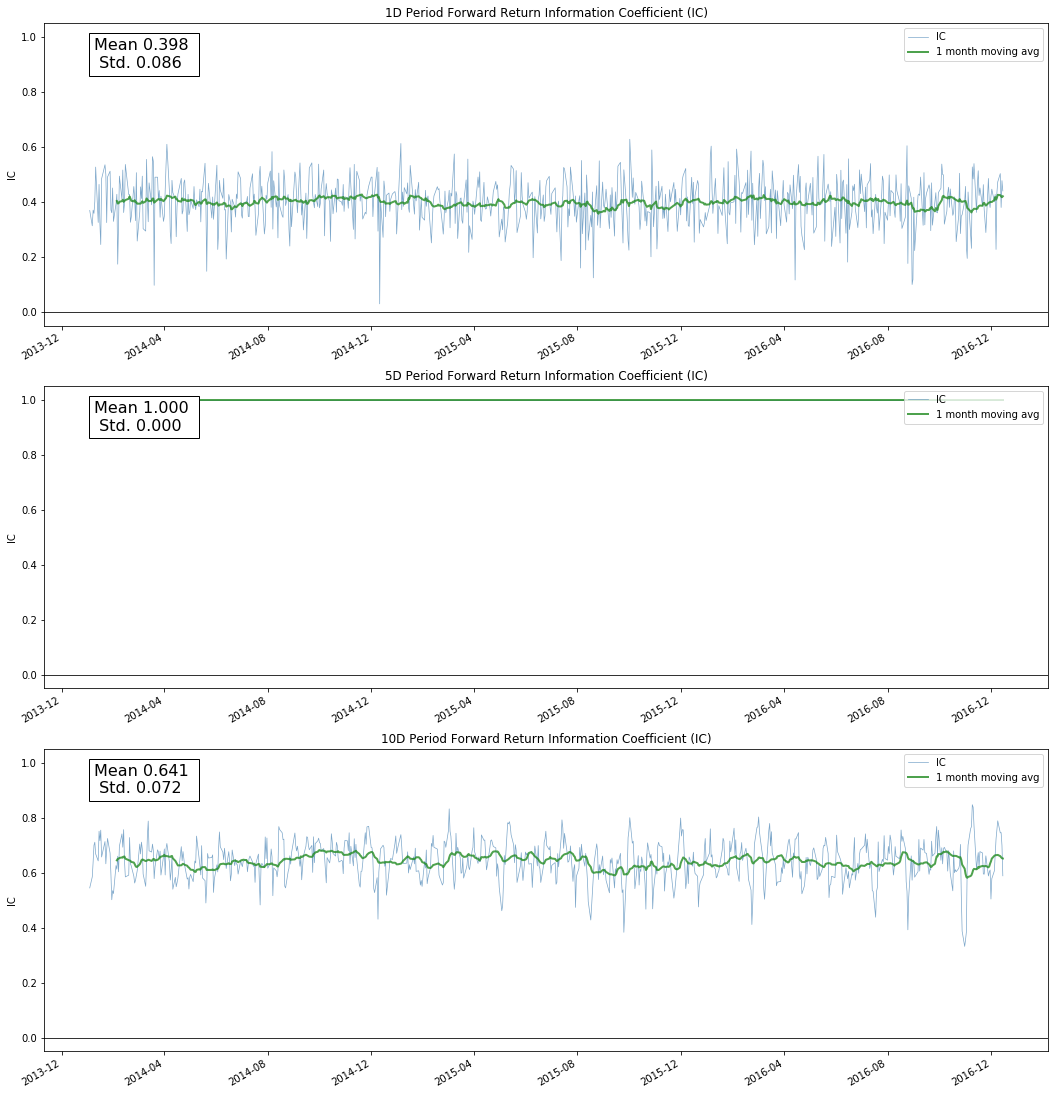

In [37]:
alphalens.plotting.plot_ic_ts(ic);

By looking at the IC each day we can understand how theoretically predicitive our factor is overtime. We like our mean IC to be high and the standard deviation, or volatility of it, to be low. We want to find consistently predictive factors.

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and h

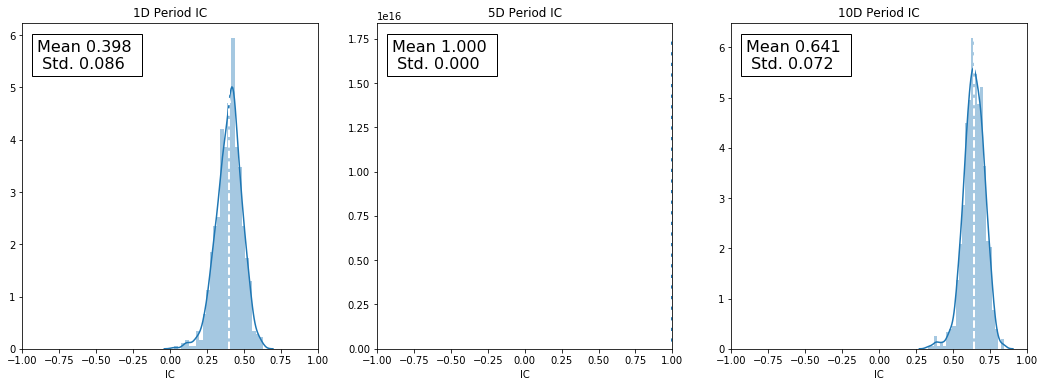

In [38]:
alphalens.plotting.plot_ic_hist(ic);

Looking at a histogram of the daily IC values can indicate how the factor behaves most of the time, where the likely IC values will fall, it also allows us to see if the factor has fat tails.

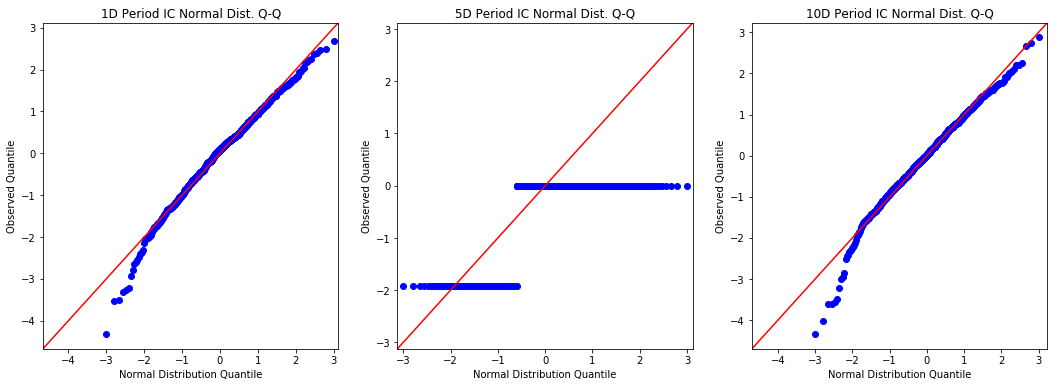

In [39]:
alphalens.plotting.plot_ic_qq(ic);

These Q-Q plots show the difference in shape between the distribution of IC values and a normal distribution. This is especially helpful in seeing how the most extreme values in the distribution affect the predicitive power.

In [40]:
mean_monthly_ic = alphalens.performance.mean_information_coefficient(factor_data, by_time='M')

In [41]:
mean_monthly_ic.head()

1D   5D       10D
date                               
2014-01-31  0.402058  1.0  0.647011
2014-02-28  0.395269  1.0  0.636958
2014-03-31  0.409086  1.0  0.663447
2014-04-30  0.406619  1.0  0.616264
2014-05-31  0.391165  1.0  0.612271

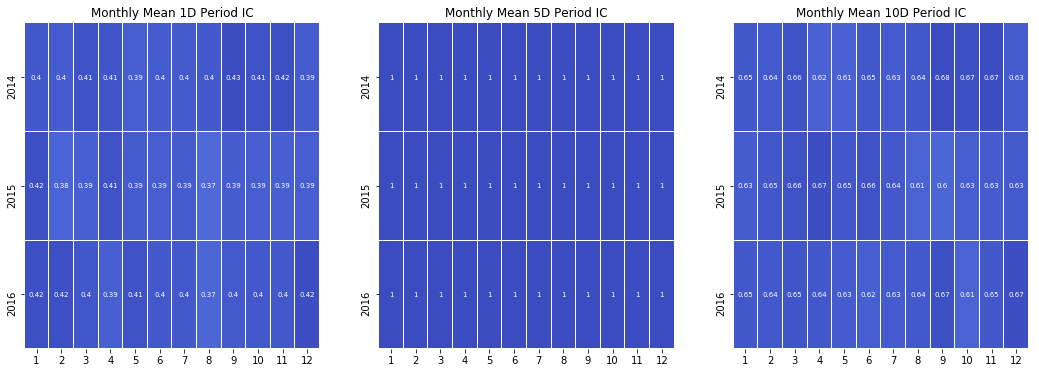

In [42]:
alphalens.plotting.plot_monthly_ic_heatmap(mean_monthly_ic);

By displaying the IC data in heatmap format we can get an idea about the consistency of the factor, and how it behaves during different market regimes/seasons.

## Information Tear Sheet

We can view all information analysis calculations together.

Information Analysis


1D            5D      10D
IC Mean             0.398  1.000000e+00    0.641
IC Std.             0.086  0.000000e+00    0.072
Risk-Adjusted IC    4.653  1.720130e+16    8.967
t-stat(IC)        126.993  4.695040e+17  244.757
p-value(IC)         0.000  0.000000e+00    0.000
IC Skew            -0.448 -1.911000e+00   -0.503
IC Kurtosis         0.728  6.520000e-01    1.142

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and h

<Figure size 432x288 with 0 Axes>

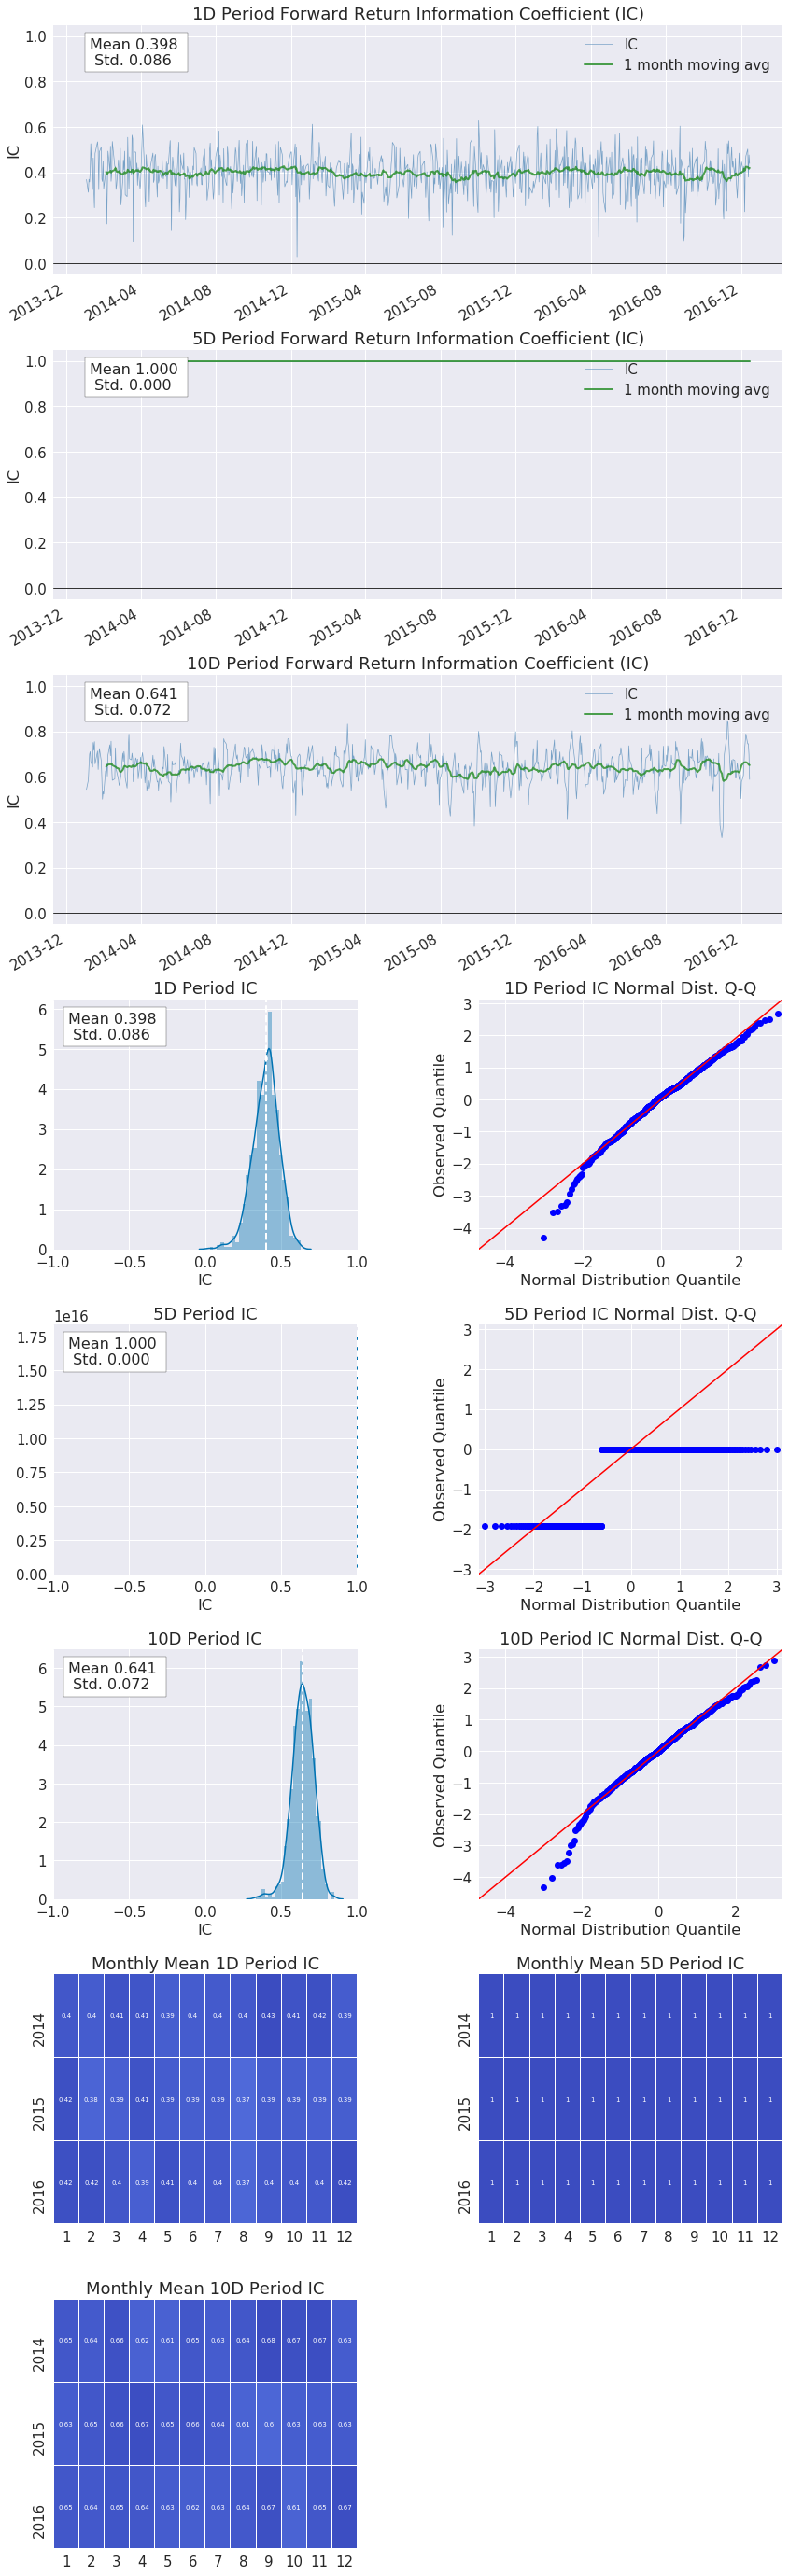

In [43]:
alphalens.tears.create_information_tear_sheet(factor_data)

# Turnover Analysis

Turnover Analysis gives us an idea about the nature of a factor's makeup and how it changes.

In [44]:
quantile_factor = factor_data['factor_quantile']
turnover_period = 1

In [45]:
quantile_turnover = pd.concat([alphalens.performance.quantile_turnover(quantile_factor, q, turnover_period)
                               for q in range(1, quantile_factor.max() + 1)], axis=1)

In [46]:
quantile_turnover.head()

1         2         3         4         5
date                                                        
2014-01-03       NaN       NaN       NaN       NaN       NaN
2014-01-06  0.400000  0.617647  0.794118  0.647059  0.323529
2014-01-07  0.527778  0.500000  0.705882  0.628571  0.361111
2014-01-08  0.472222  0.513514  0.571429  0.527778  0.361111
2014-01-09  0.416667  0.611111  0.555556  0.555556  0.388889

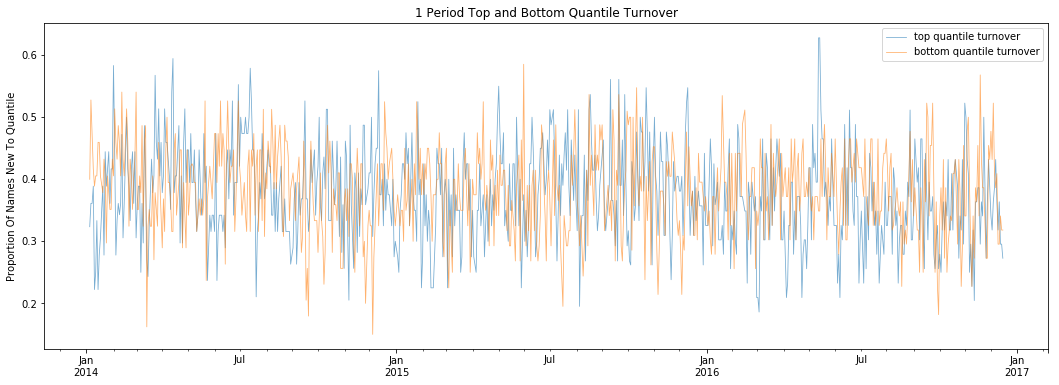

In [47]:
alphalens.plotting.plot_top_bottom_quantile_turnover(quantile_turnover, turnover_period)

Factor turnover is important as it indicates the incorporation of new information and the make up of the extremes of a signal. By looking at the new additions to the sets of top and bottom quantiles we can see how much of this factor is getting remade everyday.

In [48]:
factor_autocorrelation = alphalens.performance.factor_rank_autocorrelation(factor_data, turnover_period)

In [49]:
factor_autocorrelation.head()

date
2014-01-03         NaN
2014-01-06    0.688318
2014-01-07    0.643125
2014-01-08    0.748377
2014-01-09    0.663192
Name: 1, dtype: float64

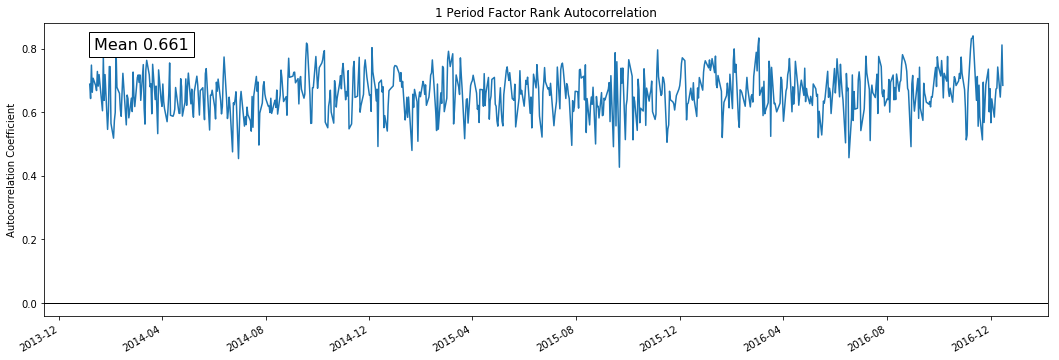

In [50]:
alphalens.plotting.plot_factor_rank_auto_correlation(factor_autocorrelation);

The autocorrelation of the factor indicates to us the persistence of the signal itself.

## Turnover Tear Sheet

We can view all turnover calculations together.

Turnover Analysis


10D     1D     5D
Quantile 1 Mean Turnover   0.735  0.382  0.759
Quantile 2 Mean Turnover   0.793  0.608  0.800
Quantile 3 Mean Turnover   0.723  0.594  0.715
Quantile 4 Mean Turnover   0.778  0.596  0.797
Quantile 5 Mean Turnover   0.768  0.374  0.776

1D     5D    10D
Mean Factor Rank Autocorrelation  0.661 -0.074 -0.007

<Figure size 432x288 with 0 Axes>

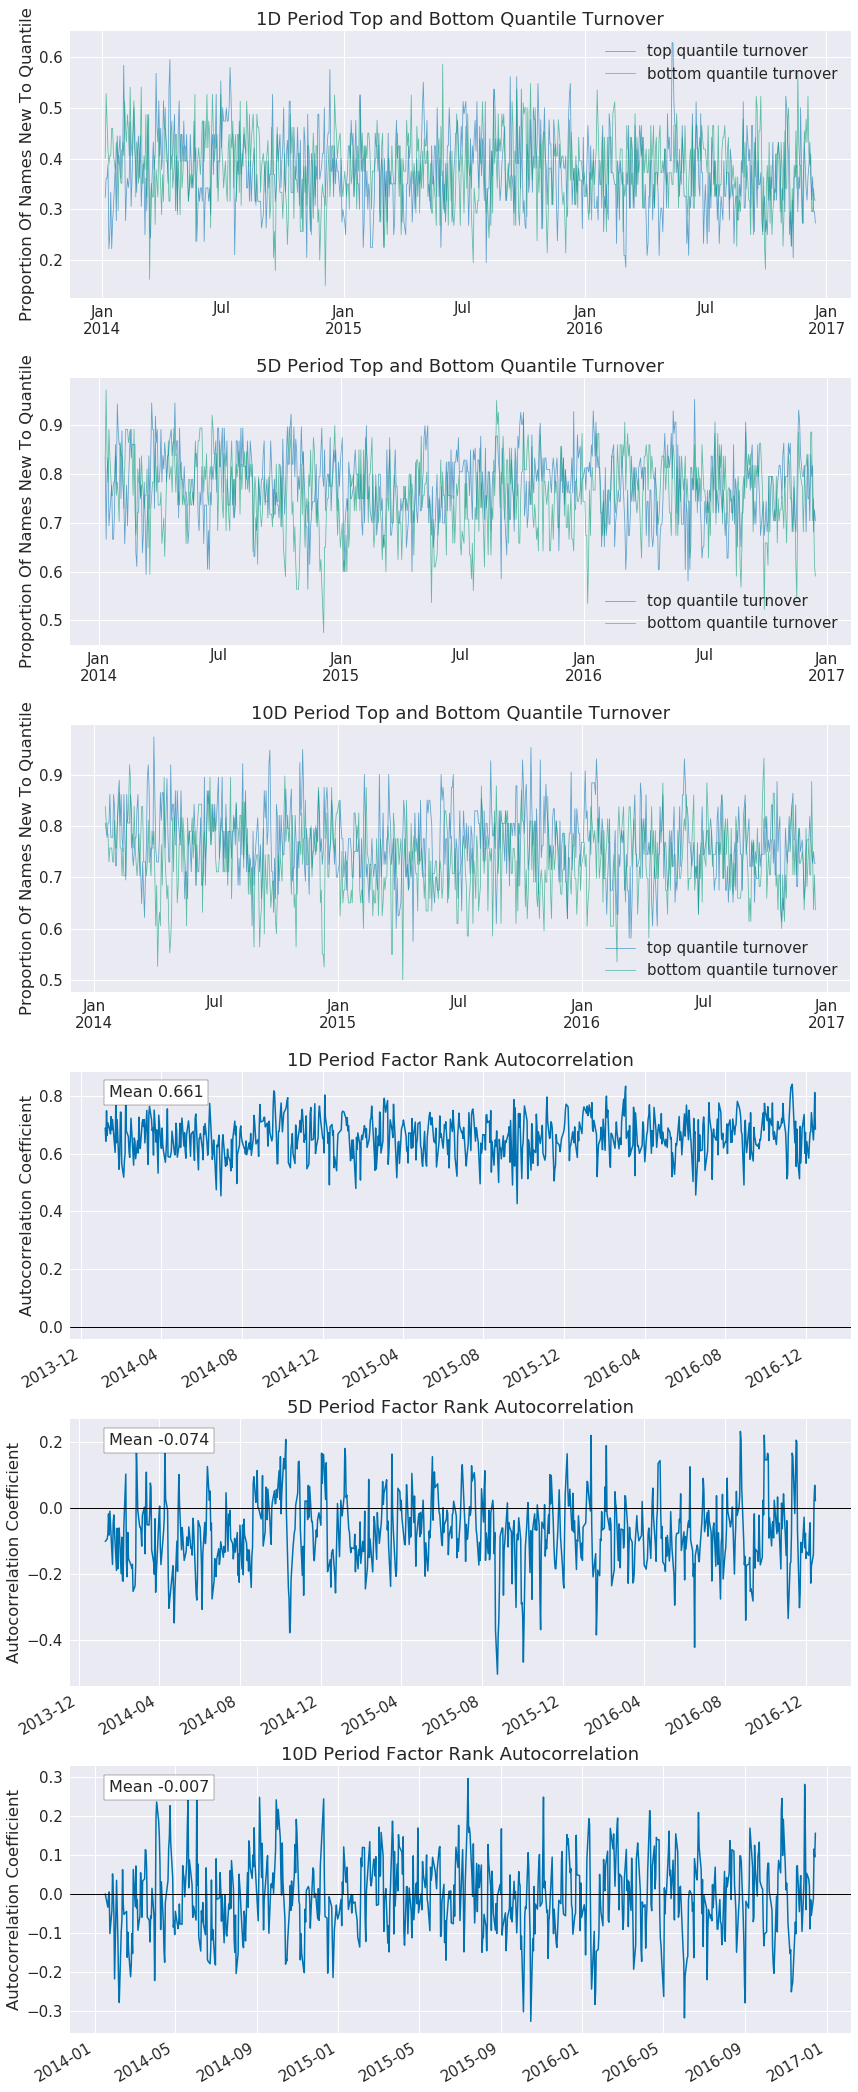

In [51]:
alphalens.tears.create_turnover_tear_sheet(factor_data)

# Event Style Returns Analysis

Looking at the average cumulative return in a window before and after a factor can indicate to us how long the predicative power of a factor lasts. This tear sheet takes a while to run.

**NOTE:** This tear sheet takes in an extra argument `pricing`.

<Figure size 432x288 with 0 Axes>

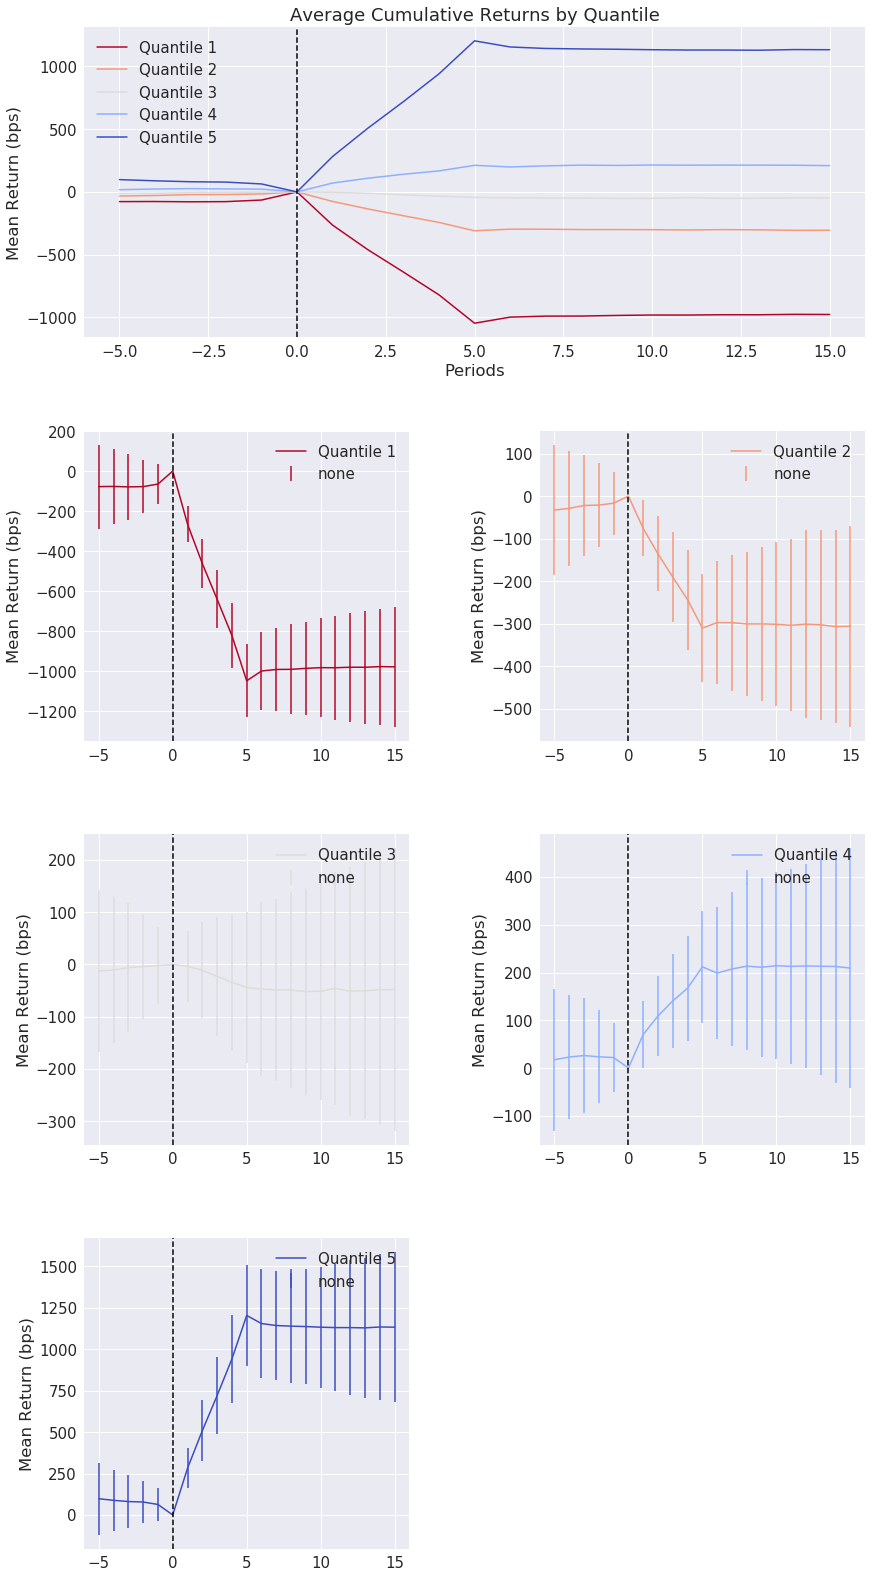

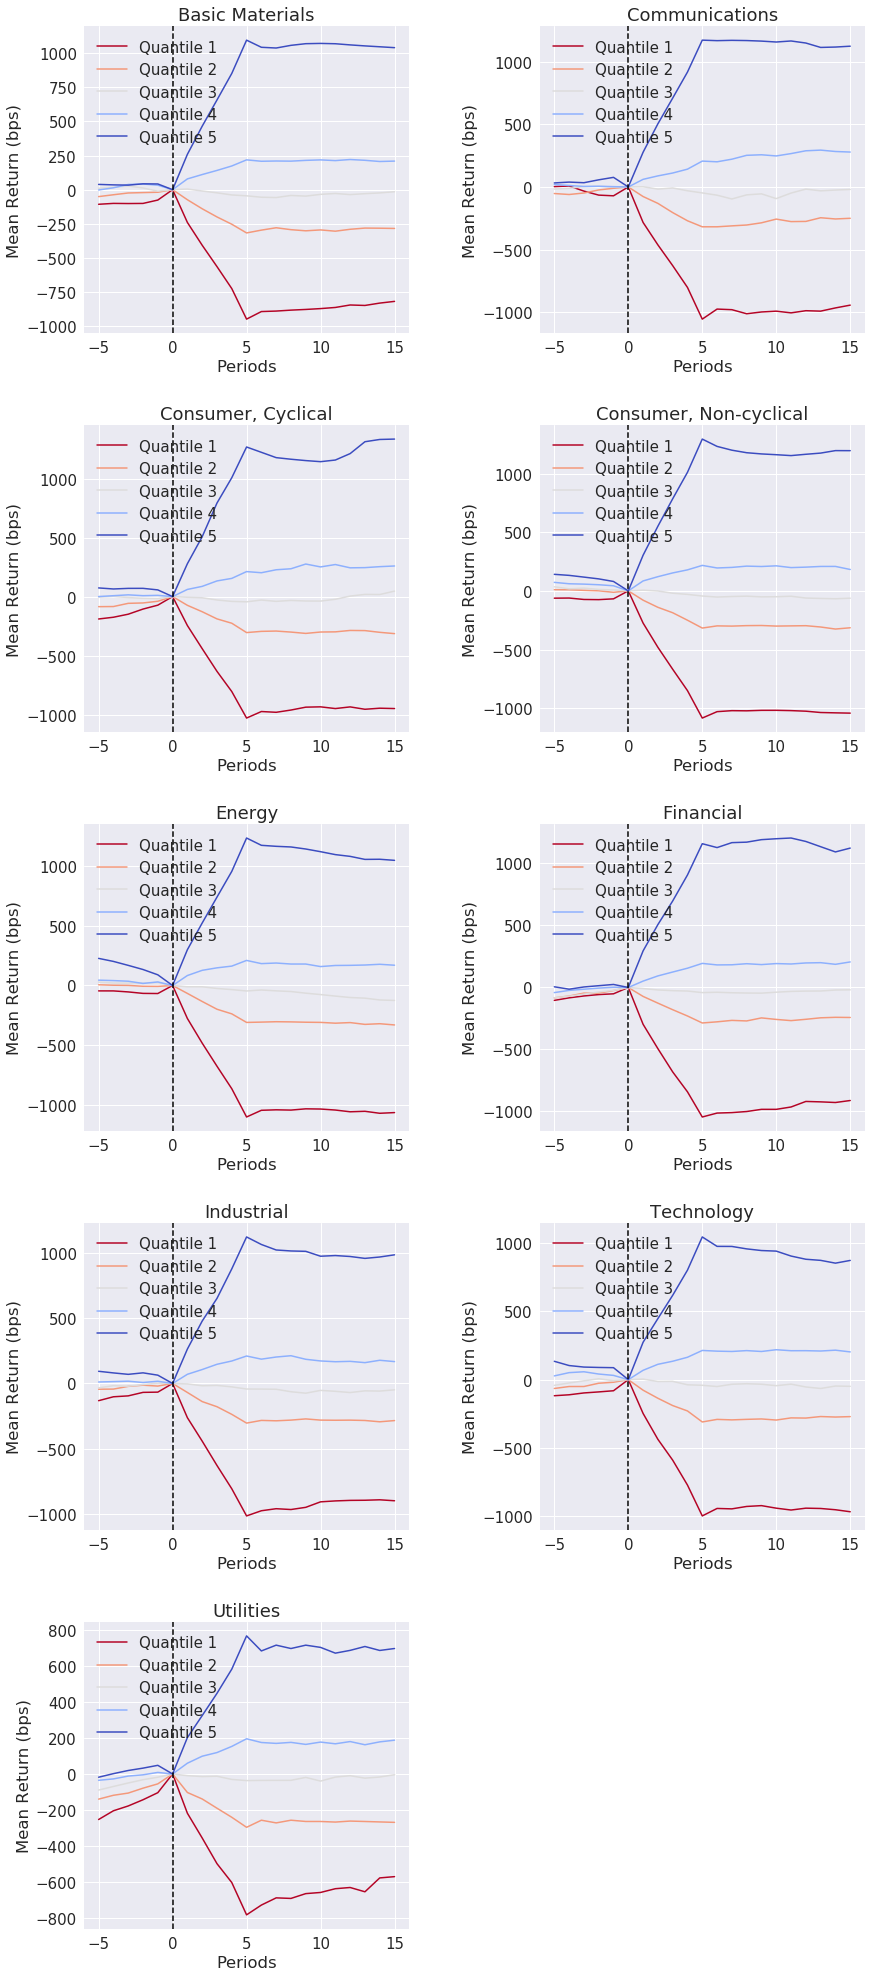

In [52]:
alphalens.tears.create_event_returns_tear_sheet(factor_data, pricing, by_group=True)

# Groupwise

Many of the plots in Alphalens can be viewed on their own by grouping if grouping information is provided. The returns and information tear sheets can be viewed groupwise by passing in the `by_group=True` argument.

In [53]:
ic_by_sector = alphalens.performance.mean_information_coefficient(factor_data, by_group=True)

In [54]:
ic_by_sector.head()

1D   5D       10D
group                                          
Basic Materials         0.401431  1.0  0.639817
Communications          0.388177  1.0  0.597519
Consumer, Cyclical      0.370708  1.0  0.613210
Consumer, Non-cyclical  0.396043  1.0  0.634987
Energy                  0.390746  1.0  0.629067

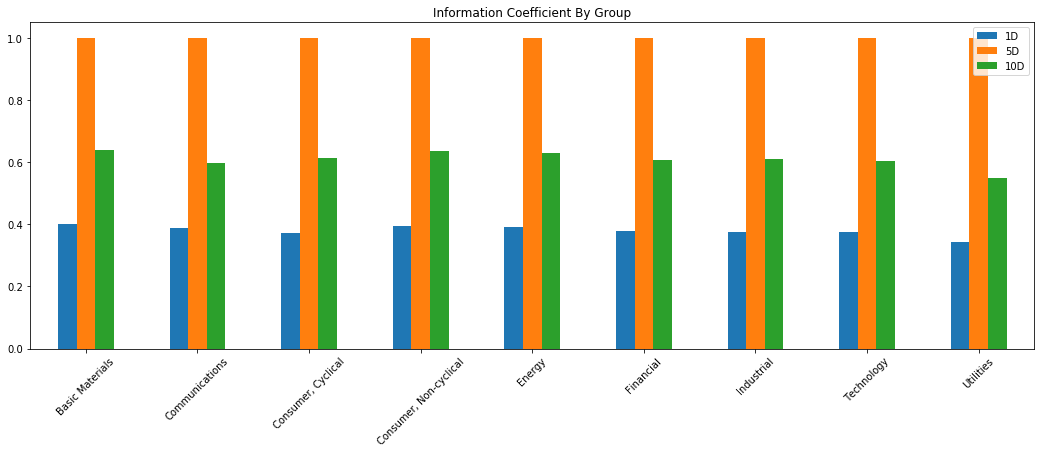

In [55]:
alphalens.plotting.plot_ic_by_group(ic_by_sector);

In [56]:
mean_return_quantile_sector, mean_return_quantile_sector_err = alphalens.performance.mean_return_by_quantile(factor_data, by_group=True)

In [57]:
mean_return_quantile_sector.head()

1D        5D       10D
factor_quantile group                                               
1               Basic Materials        -0.023967 -0.097709 -0.092258
                Communications         -0.026094 -0.103789 -0.097868
                Consumer, Cyclical     -0.022327 -0.097333 -0.087346
                Consumer, Non-cyclical -0.026273 -0.107828 -0.101544
                Energy                 -0.027367 -0.112123 -0.106441

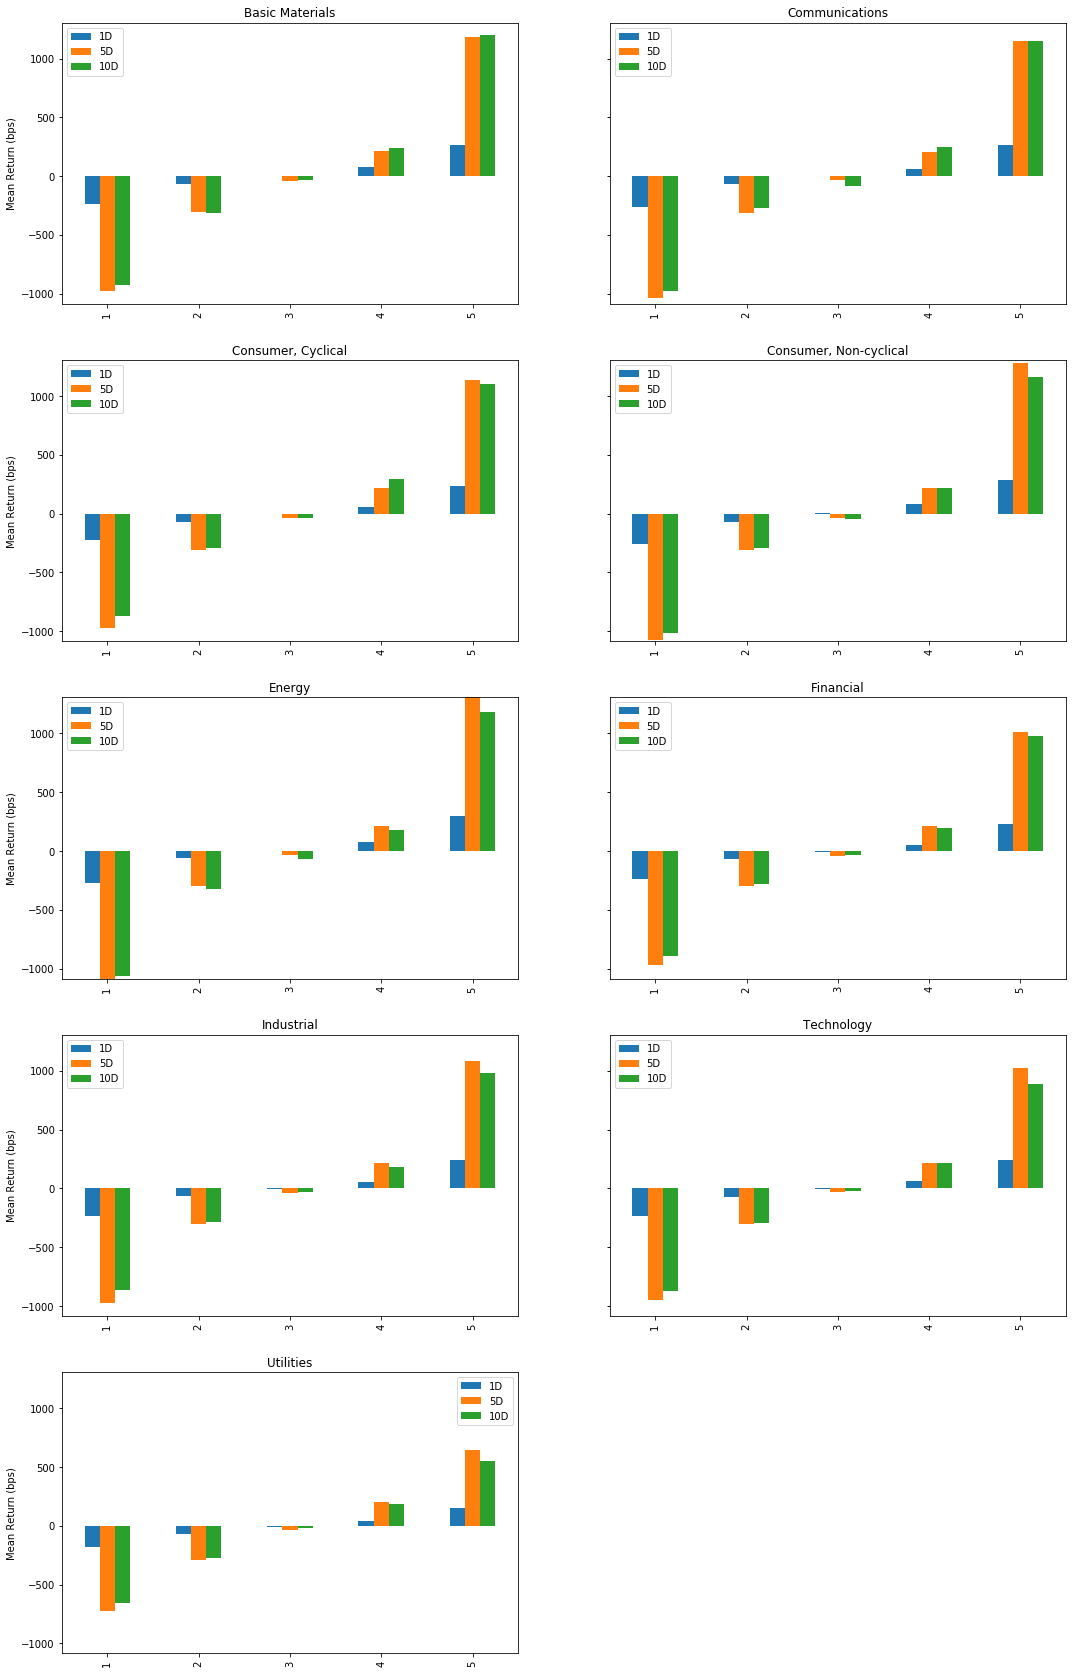

In [58]:
alphalens.plotting.plot_quantile_returns_bar(mean_return_quantile_sector, by_group=True);

# Summary Tear Sheet

There are a lot of plots above. If you want a quick snapshot of how the alpha factor performs consider the summary tear sheet.

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -0.754386  0.000000 -0.101266  0.065296  30466  20.252475
2               -0.140230  0.019108 -0.028340  0.020521  30313  20.150767
3               -0.082569  0.058559 -0.002570  0.014367  30093  20.004520
4               -0.041026  0.162500  0.023167  0.020577  29351  19.511271
5               -0.003559  5.847826  0.119472  0.142872  30208  20.080967

Returns Analysis


1D        5D      10D
Ann. alpha                                     2674.957  1445.525   27.810
beta                                              0.512     1.660    0.952
Mean Period Wise Return Top Quantile (bps)      264.852   224.966  104.861
Mean Period Wise Return Bottom Quantile (bps)  -251.009  -215.202 -100.526
Mean Period Wise Spread (bps)                   513.992   438.067  204.443

Information Analysis


1D            5D      10D
IC Mean             0.398  1.000000e+00    0.641
IC Std.             0.086  0.000000e+00    0.072
Risk-Adjusted IC    4.653  1.720130e+16    8.967
t-stat(IC)        126.993  4.695040e+17  244.757
p-value(IC)         0.000  0.000000e+00    0.000
IC Skew            -0.448 -1.911000e+00   -0.503
IC Kurtosis         0.728  6.520000e-01    1.142

Turnover Analysis


10D     1D     5D
Quantile 1 Mean Turnover   0.735  0.382  0.759
Quantile 2 Mean Turnover   0.793  0.608  0.800
Quantile 3 Mean Turnover   0.723  0.594  0.715
Quantile 4 Mean Turnover   0.778  0.596  0.797
Quantile 5 Mean Turnover   0.768  0.374  0.776

1D     5D    10D
Mean Factor Rank Autocorrelation  0.661 -0.074 -0.007

<Figure size 432x288 with 0 Axes>

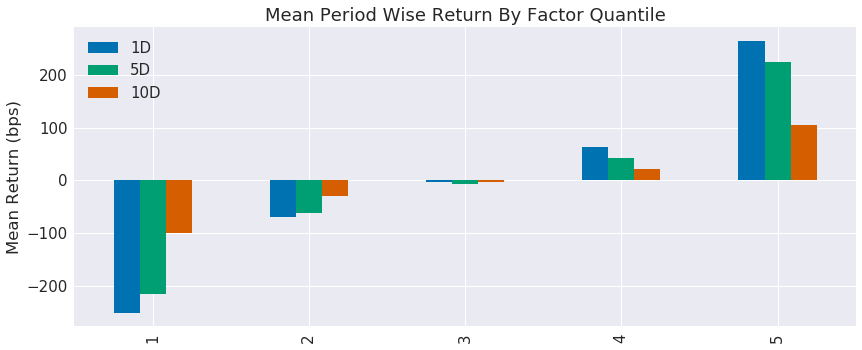

In [59]:
alphalens.tears.create_summary_tear_sheet(factor_data)

# The Whole Thing

If you want to see all of the results create a full tear sheet. By passing in the factor data you can analyze all of the above statistics and plots at once.

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -0.754386  0.000000 -0.101266  0.065296  30466  20.252475
2               -0.140230  0.019108 -0.028340  0.020521  30313  20.150767
3               -0.082569  0.058559 -0.002570  0.014367  30093  20.004520
4               -0.041026  0.162500  0.023167  0.020577  29351  19.511271
5               -0.003559  5.847826  0.119472  0.142872  30208  20.080967

Returns Analysis


1D        5D      10D
Ann. alpha                                     2674.957  1445.525   27.810
beta                                              0.512     1.660    0.952
Mean Period Wise Return Top Quantile (bps)      264.852   224.966  104.861
Mean Period Wise Return Bottom Quantile (bps)  -251.009  -215.202 -100.526
Mean Period Wise Spread (bps)                   513.992   438.067  204.443

/opt/conda/lib/python3.6/site-packages/pandas/core/indexes/datetimes.py:962: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


<Figure size 432x288 with 0 Axes>

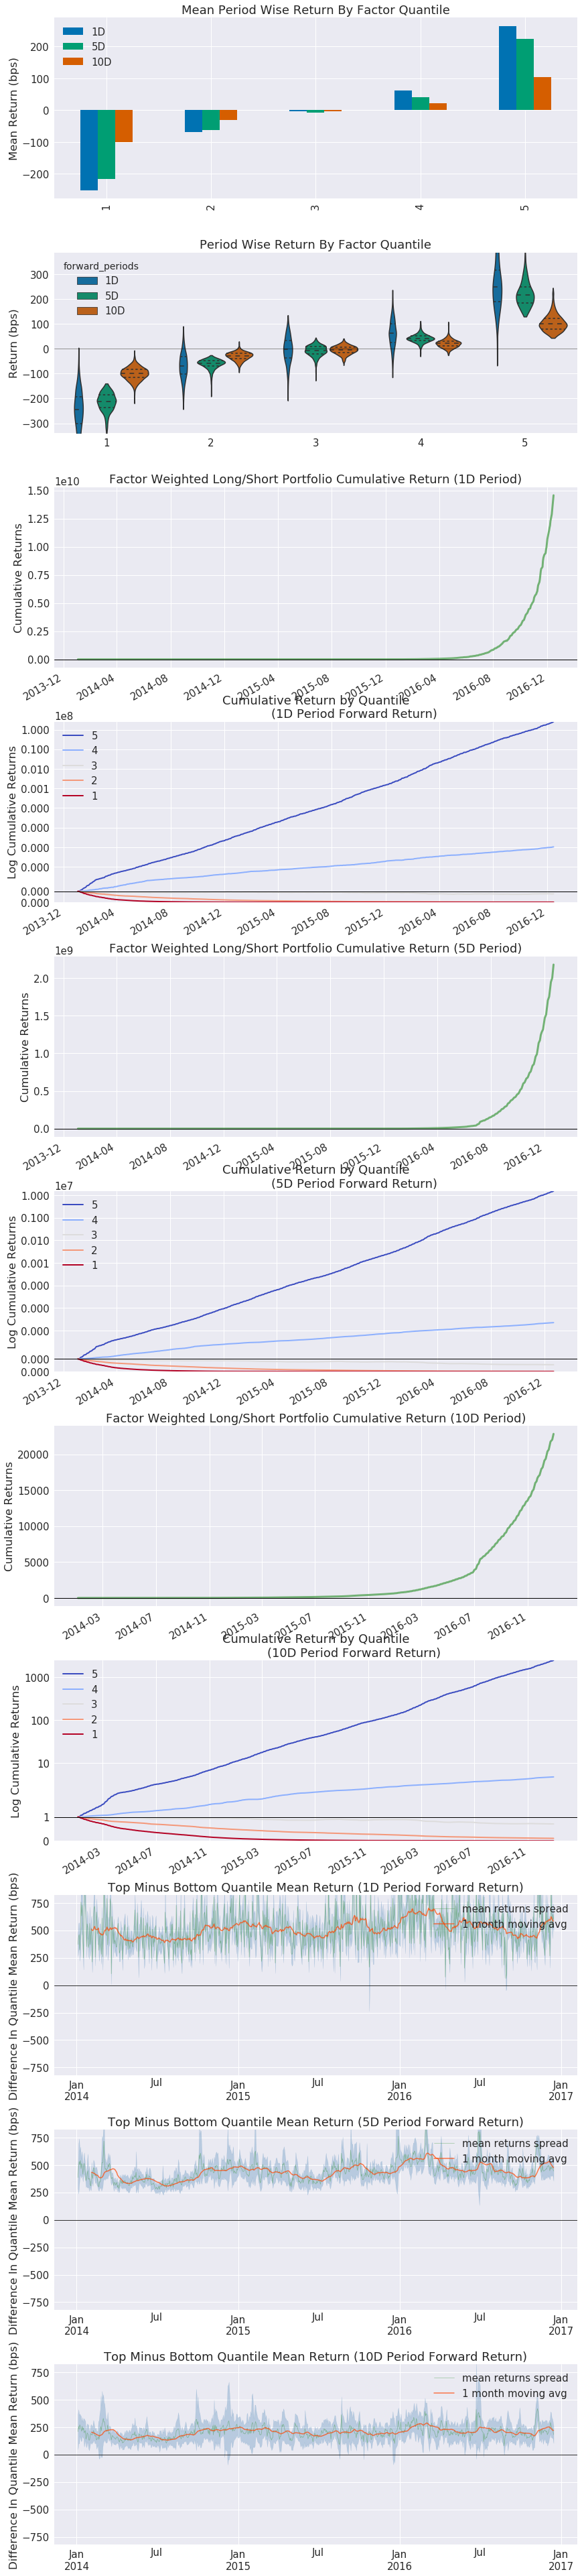

Information Analysis


1D            5D      10D
IC Mean             0.398  1.000000e+00    0.641
IC Std.             0.086  0.000000e+00    0.072
Risk-Adjusted IC    4.653  1.720130e+16    8.967
t-stat(IC)        126.993  4.695040e+17  244.757
p-value(IC)         0.000  0.000000e+00    0.000
IC Skew            -0.448 -1.911000e+00   -0.503
IC Kurtosis         0.728  6.520000e-01    1.142

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and h

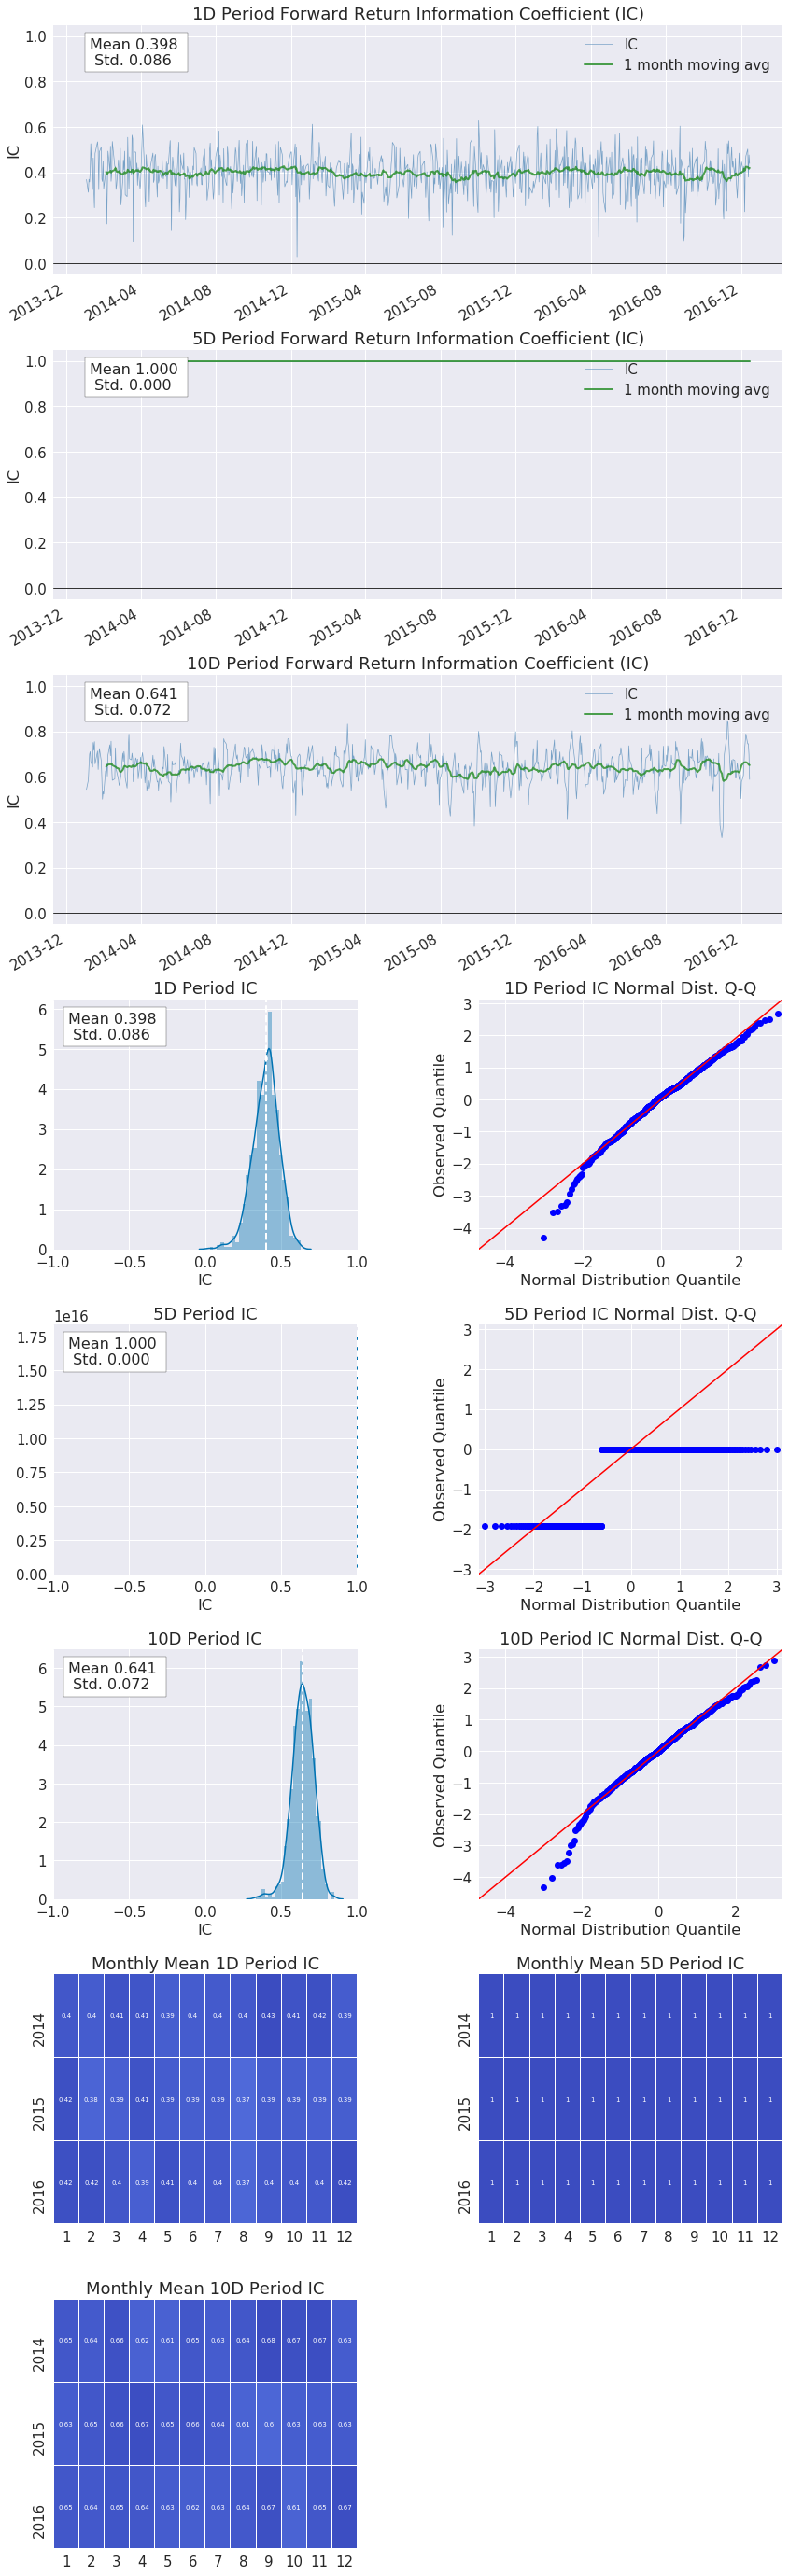

Turnover Analysis


10D     1D     5D
Quantile 1 Mean Turnover   0.735  0.382  0.759
Quantile 2 Mean Turnover   0.793  0.608  0.800
Quantile 3 Mean Turnover   0.723  0.594  0.715
Quantile 4 Mean Turnover   0.778  0.596  0.797
Quantile 5 Mean Turnover   0.768  0.374  0.776

1D     5D    10D
Mean Factor Rank Autocorrelation  0.661 -0.074 -0.007

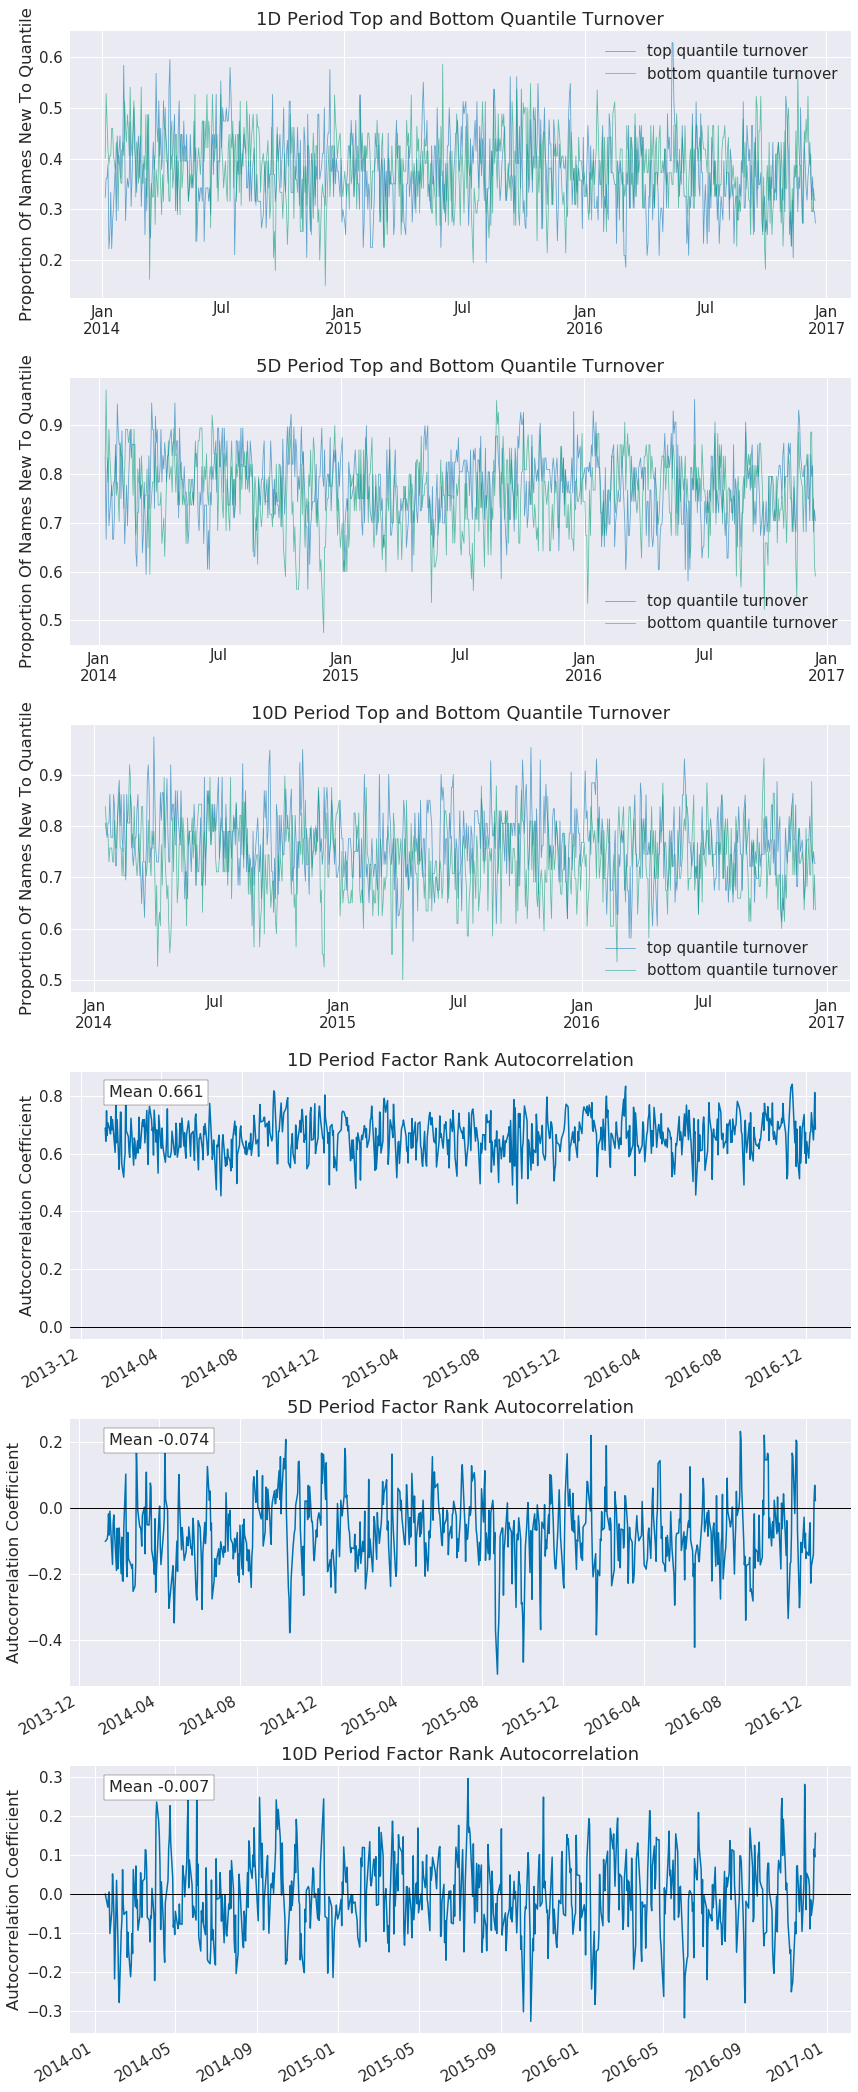

In [60]:
alphalens.tears.create_full_tear_sheet(factor_data)